# CAPSTONE PROJECT - BATTLE OF THE NEIGHBORHOODS
## Venue Recommendations to place a Restaurant

## I. INTRODUCTION

Due in part to business and immigration, United States has hispanic presence across several States, on which there is a widespread likability of Mexican food. In Addition, more traditional Mexican dishes have also grown in popularity in the United States,like tortillas, salsa, chips, chili, burritos, and tacos. Therefore, the intention of this project is to collect information and provide recommendations on potential places to place a Mexican restaurant based on statistical data, open sources and FourSquare API.  

## II. DATA SOURCES
This demonstration will use the following data sources:

#### Source 1. United States Census 2010

#### Source 2. Maryland Government Data Census

#### Source 3. Foursquare API




## III. METHODOLOGY

#### 1. Python Libraries.
This sections imports the required Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Folium Maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

# Clustering
from sklearn.cluster import KMeans

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



#### 2. Data Sources Load.
The following data sources will be used to perform the statistical analysis:

In [2]:
#US Government Census on Immigration
df=pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010/modified-race-data-2010/stco-mr2010-1.csv')

In [3]:
#Maryland Census on Population across Counties
Maryland_Data=pd.read_csv('https://opendata.arcgis.com/datasets/eb706b48117b43d482c63d02017fc3ff_1.csv')

#### 3. Data Exploration
##### Data from US Government Census Exploration

In [4]:
#Review the layout
df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,SEX,ORIGIN,AGEGRP,IMPRACE,RESPOP
0,50,1,1,Alabama,Autauga County,1,1,1,1,1337
1,50,1,1,Alabama,Autauga County,1,1,1,2,356
2,50,1,1,Alabama,Autauga County,1,1,1,3,2
3,50,1,1,Alabama,Autauga County,1,1,1,4,13
4,50,1,1,Alabama,Autauga County,1,1,1,6,33


In [5]:
#Filter the State on which the placement of the Restaurant is planned
Maryland_df = df[df.STNAME == 'Maryland']

In [6]:
#Filter the features of main target audience (ORIGIN 2, IMPRACE 1 = Hispanic, AGEGRP 7,8,9 = Age above 30 years to 60 years)
Maryland_Hispanic_df = Maryland_df[(Maryland_df.ORIGIN==2) & (Maryland_df.IMPRACE==1) & ((Maryland_df.AGEGRP==7)|(Maryland_df.AGEGRP==8)|(Maryland_df.AGEGRP==9))]
Maryland_Hispanic_df.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,SEX,ORIGIN,AGEGRP,IMPRACE,RESPOP
486942,50,24,1,Maryland,Allegany County,1,2,7,1,96
486944,50,24,1,Maryland,Allegany County,1,2,8,1,65
486948,50,24,1,Maryland,Allegany County,1,2,9,1,60
487150,50,24,1,Maryland,Allegany County,2,2,7,1,15
487154,50,24,1,Maryland,Allegany County,2,2,8,1,28


In [7]:
#Group the Counties with the most Hispanic presence
Maryland_Hispanic_df.groupby('CTYNAME').agg({'RESPOP' : 'sum'}).sort_values('RESPOP',ascending=False).head()

,RESPOP
CTYNAME,
Montgomery County,37272
Prince George's County,27380
Anne Arundel County,7084
Baltimore County,6627
Baltimore city,5262


##### Data from Maryland Government Exploration

In [8]:
#As the dataset contains several columns, we have increased the fields limit to 100.
pd.set_option('display.max_columns', 100)
Maryland_Data.head()
#The field HISP corresponds to the number of Hispanics.
#The field PHISP  corresponds to the percentage of Hispanics for any given Postal Code (ZCTA5CE10)

,OBJECTID_1,ZCTA5CE10,FIRST_STAT,FIRST_GEOI,FIRST_CLAS,FIRST_MTFC,FIRST_FUNC,ZCTA5N,STATE,AREALAND,AREAWATR,POP100,HU100,NHW,NHB,NHAI,NHA,NHNH,NHO,NHT,HISP,PNHW,PNHB,PNHAI,PNHA,PNHNH,PNHO,PNHT,PHISP,POP65_,PCTPOP65_,MEDAGE,VACNS,PVACNS,PHOWN,PWOMORT,PRENT,PLT18SP,REPORT_2_P,REPORT_9_P
0,1,20601,24,2420601,B5,G6350,S,20601,24,115635266,387684,24156,8722,9785,11146,155,880,11,48,849,1282,40.5,46.1,0.6,3.6,0.0,0.2,3.5,5.3,1922,8.0,37.3,376,4.3,71.1,11.2,19.9,30.4,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
1,2,20602,24,2420602,B5,G6350,S,20602,24,35830723,352762,24955,9736,8466,13054,116,731,15,58,999,1516,33.9,52.3,0.5,2.9,0.1,0.2,4.0,6.1,1964,7.9,32.6,769,7.9,59.7,9.0,34.4,43.6,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
2,3,20603,24,2420603,B5,G6350,S,20603,24,44239637,219356,28967,10317,9625,15025,98,1446,24,65,1091,1593,33.2,51.9,0.3,5.0,0.1,0.2,3.8,5.5,1400,4.8,34.5,531,5.1,73.8,4.7,22.6,29.9,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
3,4,20606,24,2420606,B5,G6350,S,20606,24,7501011,1248760,431,230,377,45,1,4,0,0,0,4,87.5,10.4,0.2,0.9,0.0,0.0,0.0,0.9,108,25.1,49.1,15,6.5,49.7,39.3,18.1,31.2,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
4,5,20607,24,2420607,B5,G6350,S,20607,24,54357590,448221,9802,3504,2165,6321,33,560,3,6,234,480,22.1,64.5,0.3,5.7,0.0,0.1,2.4,4.9,847,8.6,40.9,172,4.9,83.1,10.3,7.4,22.1,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...


In [9]:
##Grouping Postal Codes in Maryland with most Hispanic presence
Maryland_Data.groupby('ZCTA5CE10')['PHISP'].mean().sort_values(ascending=False)[:5]


ZCTA5CE10
20783    59.4
20737    48.1
20903    47.9
21649    44.4
20722    41.7
Name: PHISP, dtype: float64

#### 4. Data Analysis
##### 4.1 Filtering of data source

In [10]:
##Based on the Data Exploration, filter the TOp 10 Zip Codes with greather percentage of hispanic presence.
Maryland_Data_Relevant_ZipCode=Maryland_Data[(Maryland_Data.ZCTA5CE10==20783)|
                                                (Maryland_Data.ZCTA5CE10==20737)|
                                                (Maryland_Data.ZCTA5CE10==20903)|
                                                (Maryland_Data.ZCTA5CE10==21649)|
                                                (Maryland_Data.ZCTA5CE10==20722)|
                                                (Maryland_Data.ZCTA5CE10==20781)|
                                                (Maryland_Data.ZCTA5CE10==20877)|
                                                (Maryland_Data.ZCTA5CE10==20902)|
                                                (Maryland_Data.ZCTA5CE10==20782)|
                                                (Maryland_Data.ZCTA5CE10==20712)]
Maryland_Data_Relevant_ZipCode.head()

,OBJECTID_1,ZCTA5CE10,FIRST_STAT,FIRST_GEOI,FIRST_CLAS,FIRST_MTFC,FIRST_FUNC,ZCTA5N,STATE,AREALAND,AREAWATR,POP100,HU100,NHW,NHB,NHAI,NHA,NHNH,NHO,NHT,HISP,PNHW,PNHB,PNHAI,PNHA,PNHNH,PNHO,PNHT,PHISP,POP65_,PCTPOP65_,MEDAGE,VACNS,PVACNS,PHOWN,PWOMORT,PRENT,PLT18SP,REPORT_2_P,REPORT_9_P
66,67,20712,24,2420712,B5,G6350,S,20712,24,1892811,12394,9031,3927,1112,4630,27,197,2,36,137,2890,12.3,51.3,0.3,2.2,0.0,0.4,1.5,32.0,589,6.5,32.6,264,6.7,23.0,13.6,73.4,49.0,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
72,73,20722,24,2420722,B5,G6350,S,20722,24,3810192,79461,5711,1945,740,2187,18,255,0,16,111,2384,13.0,38.3,0.3,4.5,0.0,0.3,1.9,41.7,512,9.0,35.0,191,9.8,60.8,14.9,28.6,35.7,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
79,80,20737,24,2420737,B5,G6350,S,20737,24,10724278,76543,20684,6227,2449,7202,47,619,8,52,368,9939,11.8,34.8,0.2,3.0,0.0,0.3,1.8,48.1,1255,6.1,29.7,465,7.5,42.8,14.7,49.8,36.9,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
105,106,20781,24,2420781,B5,G6350,S,20781,24,6312229,205096,11440,4093,2786,3552,38,300,8,45,219,4492,24.4,31.0,0.3,2.6,0.1,0.4,1.9,39.3,766,6.7,32.9,282,6.9,47.5,15.4,43.9,34.6,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...
106,107,20782,24,2420782,B5,G6350,S,20782,24,10973600,99086,30560,11552,4656,13941,62,945,17,96,549,10294,15.2,45.6,0.2,3.1,0.1,0.3,1.8,33.7,2885,9.4,32.6,742,6.4,36.2,18.2,55.8,40.7,http://mdpgis.mdp.state.md.us/Census2010/PDF/0...,http://mdpgis.mdp.state.md.us/census2010/PDF/0...


In [11]:
#Evaluate the population number of Hispanics
Maryland_Data_Relevant_ZipCode.groupby('ZCTA5CE10').agg({'HISP' : 'sum'}).sort_values('HISP',ascending=False)[:5]

,HISP
ZCTA5CE10,
20783,26424
20902,16532
20877,12872
20903,11323
20782,10294


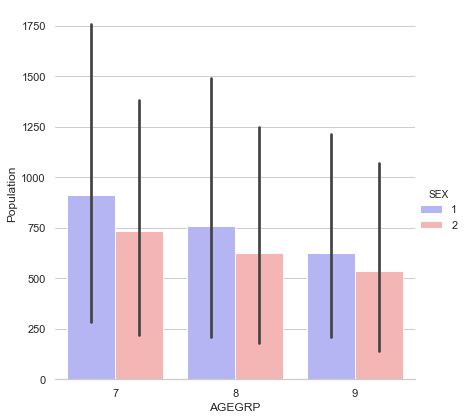

In [12]:
## Targeted audience Age
##Distribution of the target age of audience
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show age, sex and population
g = sns.catplot(x="AGEGRP", y="RESPOP", hue="SEX", data=Maryland_Hispanic_df,
                height=6, kind="bar", palette="bwr",legend=True,)
g.despine(left=True)
g.set_ylabels("Population")

##### 4.2 Foursquare

In [13]:
##Connect to Foursquare
CLIENT_ID = 'XI4145G2BEXMPHOBXKGYGT5TXR2K4DHL4F3VGSB22UX5SGBO' # your Foursquare ID
CLIENT_SECRET = 'I3PCJAWJ5KBXAPOZOHQ5SH3COJ2G4JZDMOVTNV12QYOEA4DX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XI4145G2BEXMPHOBXKGYGT5TXR2K4DHL4F3VGSB22UX5SGBO
CLIENT_SECRET:I3PCJAWJ5KBXAPOZOHQ5SH3COJ2G4JZDMOVTNV12QYOEA4DX


In [14]:
##The ZIP Codes of interest point out to the city of Adelphi.
address = 'Adelphi, MD'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

39.0030666 -76.9721023


In [15]:
search_query = ''
radius = 500
print(search_query + ' .... OK!')

 .... OK!


In [16]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=XI4145G2BEXMPHOBXKGYGT5TXR2K4DHL4F3VGSB22UX5SGBO&client_secret=I3PCJAWJ5KBXAPOZOHQ5SH3COJ2G4JZDMOVTNV12QYOEA4DX&ll=39.0030666,-76.9721023&v=20180604&query=&radius=500&limit=30'

In [20]:
results = requests.get(url).json()

In [21]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id
0,4bbb344b1261d13a9b5deb98,Bank of America,"[{'id': '4bf58dd8d48988d10a951735', 'name': 'B...",v-1571888566,False,9111 Riggs Rd,39.003827,-76.970979,"[{'label': 'display', 'lat': 39.00382745145823...",128,20783,US,Adelphi,MD,United States,"[9111 Riggs Rd, Adelphi, MD 20783, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4baac25af964a520f9843ae3,Basil's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1571888566,False,9113 Riggs Rd,39.003806,-76.970784,"[{'label': 'display', 'lat': 39.00380609518559...",140,20783,US,Adelphi,MD,United States,"[9113 Riggs Rd, Adelphi, MD 20783, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4eca8edd30f8b09c0f892993,Cool Spring ES,"[{'id': '4bf58dd8d48988d1ab941735', 'name': 'S...",v-1571888566,False,NaN,39.002763,-76.972798,"[{'label': 'display', 'lat': 39.00276294590971...",69,20783,US,Hyattsville,MD,United States,"[Hyattsville, MD 20783, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4b99bd0ff964a520448f35e3,7-Eleven,"[{'id': '4d954b0ea243a5684a65b473', 'name': 'C...",v-1571888566,False,9151 Riggs Rd,39.004421,-76.968715,"[{'label': 'display', 'lat': 39.0044208023493,...",329,20783,US,Adelphi,MD,United States,"[9151 Riggs Rd (Adelphi Rd), Adelphi, MD 20783...",Adelphi Rd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4ce3ffee0eec8cfa0191a12a,Rite Aid,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1571888566,False,9139 Riggs Rd,39.003697,-76.969983,"[{'label': 'display', 'lat': 39.00369666813991...",196,20783,US,Adelphi,MD,United States,"[9139 Riggs Rd, Adelphi, MD 20783, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
##Transformation of DataFrame
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Bank of America,Bank,9111 Riggs Rd,39.003827,-76.970979,"[{'label': 'display', 'lat': 39.00382745145823...",128,20783,US,Adelphi,MD,United States,"[9111 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4bbb344b1261d13a9b5deb98
1,Basil's Pizza,Pizza Place,9113 Riggs Rd,39.003806,-76.970784,"[{'label': 'display', 'lat': 39.00380609518559...",140,20783,US,Adelphi,MD,United States,"[9113 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4baac25af964a520f9843ae3
2,Cool Spring ES,Student Center,NaN,39.002763,-76.972798,"[{'label': 'display', 'lat': 39.00276294590971...",69,20783,US,Hyattsville,MD,United States,"[Hyattsville, MD 20783, United States]",NaN,4eca8edd30f8b09c0f892993
3,7-Eleven,Convenience Store,9151 Riggs Rd,39.004421,-76.968715,"[{'label': 'display', 'lat': 39.0044208023493,...",329,20783,US,Adelphi,MD,United States,"[9151 Riggs Rd (Adelphi Rd), Adelphi, MD 20783...",Adelphi Rd,4b99bd0ff964a520448f35e3
4,Rite Aid,Pharmacy,9139 Riggs Rd,39.003697,-76.969983,"[{'label': 'display', 'lat': 39.00369666813991...",196,20783,US,Adelphi,MD,United States,"[9139 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4ce3ffee0eec8cfa0191a12a


###### 4.2.1 Foursquare data filtering

In [23]:
##Filtering of information with only ZIP Codes of interest
LandmarksHispanicPlaces=dataframe_filtered[(dataframe_filtered.postalCode=='20783')|(dataframe_filtered.postalCode=='20737')|(dataframe_filtered.postalCode=='20903')|(dataframe_filtered.postalCode=='21649')|(dataframe_filtered.postalCode=='20722')|(dataframe_filtered.postalCode=='20781')|(dataframe_filtered.postalCode=='20877')|(dataframe_filtered.postalCode=='20902')|(dataframe_filtered.postalCode=='20782')|(dataframe_filtered.postalCode=='20712')|(dataframe_filtered.postalCode=='20851')|(dataframe_filtered.postalCode=='20784')|(dataframe_filtered.postalCode=='20906')|(dataframe_filtered.postalCode=='20710')|(dataframe_filtered.postalCode=='20879')]
LandmarksHispanicPlaces.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Bank of America,Bank,9111 Riggs Rd,39.003827,-76.970979,"[{'label': 'display', 'lat': 39.00382745145823...",128,20783,US,Adelphi,MD,United States,"[9111 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4bbb344b1261d13a9b5deb98
1,Basil's Pizza,Pizza Place,9113 Riggs Rd,39.003806,-76.970784,"[{'label': 'display', 'lat': 39.00380609518559...",140,20783,US,Adelphi,MD,United States,"[9113 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4baac25af964a520f9843ae3
2,Cool Spring ES,Student Center,NaN,39.002763,-76.972798,"[{'label': 'display', 'lat': 39.00276294590971...",69,20783,US,Hyattsville,MD,United States,"[Hyattsville, MD 20783, United States]",NaN,4eca8edd30f8b09c0f892993
3,7-Eleven,Convenience Store,9151 Riggs Rd,39.004421,-76.968715,"[{'label': 'display', 'lat': 39.0044208023493,...",329,20783,US,Adelphi,MD,United States,"[9151 Riggs Rd (Adelphi Rd), Adelphi, MD 20783...",Adelphi Rd,4b99bd0ff964a520448f35e3
4,Rite Aid,Pharmacy,9139 Riggs Rd,39.003697,-76.969983,"[{'label': 'display', 'lat': 39.00369666813991...",196,20783,US,Adelphi,MD,United States,"[9139 Riggs Rd, Adelphi, MD 20783, United States]",NaN,4ce3ffee0eec8cfa0191a12a


In [24]:
#Identify current Mexican Restaurants near the zone of interest
Adelphi_Mexican_Restaurants = dataframe_filtered[dataframe_filtered.categories=='Mexican Restaurant']
Adelphi_Mexican_Restaurants.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
14,Los Antojitos,Mexican Restaurant,9123 Riggs Rd,39.004088,-76.970255,"[{'label': 'display', 'lat': 39.00408767989662...",196,20740,US,College Park,MD,United States,"[9123 Riggs Rd (Adelphi Rd), College Park, MD ...",Adelphi Rd,4daf2a0f6a23e6c93499bb7c


In [25]:
#Count the landmarks close to the cities of interest
LandmarksHispanicPlaces['categories'].unique()
LandmarksHispanicPlaces.groupby('city').count()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,state,country,formattedAddress,crossStreet,id
city,,,,,,,,,,,,,,
Adelphi,15,15,14,15,15,15,15,15,15,15,15,15,2,15
Hyattsville,3,2,0,3,3,3,3,3,3,3,3,3,0,3
Silver Spring,4,3,4,4,4,4,4,4,4,4,4,4,0,4
White Oak,1,0,0,1,1,1,1,1,1,1,1,1,0,1


In [26]:
#Identify places of greather afluence of people, such as Shopping Malls.

shopping_locations = ['Adelphi Shopping Center', 38.9848891, -76.9677986,
'Adelphi Plaza', 38.9838133, -76.9754591,
'Metzerott Plaza', 39.00475429, -76.96952628]

shopping_center_loc=pd.DataFrame(np.array(shopping_locations).reshape(3,3),columns=["Shopping_Center","Latitude","Longitude"])

shopping_center_loc['Latitude'] = shopping_center_loc.Latitude.astype(float)
shopping_center_loc['Longitude'] = shopping_center_loc.Longitude.astype(float)
shopping_center_loc.shape
shopping_center_loc.head()


,Shopping_Center,Latitude,Longitude
0,Adelphi Shopping Center,38.984889,-76.967799
1,Adelphi Plaza,38.983813,-76.975459
2,Metzerott Plaza,39.004754,-76.969526


###### 4.2.2 Data transformation for Clustering

In [27]:
##Transform the data for Clustering
LandmarksHispanicPlaces_firstcolumn= pd.get_dummies(LandmarksHispanicPlaces[['categories','lat','lng']], prefix="", prefix_sep="")
LandmarksHispanicPlaces_firstcolumn['name']=LandmarksHispanicPlaces['name']
firstcolumn = [LandmarksHispanicPlaces_firstcolumn.columns[-1]] + list(LandmarksHispanicPlaces_firstcolumn.columns[:-1])
LandmarksHispanicPlaces_firstcolumn = LandmarksHispanicPlaces_firstcolumn[firstcolumn]
LandmarksHispanicPlaces_group = LandmarksHispanicPlaces_firstcolumn.groupby('name')
LandmarksHispanicPlaces_firstcolumn.head()

,name,lat,lng,American Restaurant,Bank,Building,Chinese Restaurant,Convenience Store,Deli / Bodega,Fast Food Restaurant,Financial or Legal Service,Laundry Service,Liquor Store,Mobile Phone Shop,Pharmacy,Pizza Place,Residential Building (Apartment / Condo),Sandwich Place,School,Student Center
0,Bank of America,39.003827,-76.970979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Basil's Pizza,39.003806,-76.970784,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Cool Spring ES,39.002763,-76.972798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7-Eleven,39.004421,-76.968715,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Rite Aid,39.003697,-76.969983,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


###### 4.3 k-Means Clustering

In [28]:
##Clustering
cluster_LandmarksHispanicPlaces = LandmarksHispanicPlaces_firstcolumn.drop('name',1)
kclusters=5
kmeans_ = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_LandmarksHispanicPlaces)
kmeans_.labels_

array([0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 3, 3, 3,
       0])

In [29]:
##Add the Cluster column to the DataFrame
LandmarksHispanicPlaces_firstcolumn['Cluster'] = pd.Series(kmeans_.labels_,index=LandmarksHispanicPlaces_firstcolumn.index)
LandmarksHispanicPlaces_firstcolumn.head()

,name,lat,lng,American Restaurant,Bank,Building,Chinese Restaurant,Convenience Store,Deli / Bodega,Fast Food Restaurant,Financial or Legal Service,Laundry Service,Liquor Store,Mobile Phone Shop,Pharmacy,Pizza Place,Residential Building (Apartment / Condo),Sandwich Place,School,Student Center,Cluster
0,Bank of America,39.003827,-76.970979,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Basil's Pizza,39.003806,-76.970784,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Cool Spring ES,39.002763,-76.972798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7-Eleven,39.004421,-76.968715,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
4,Rite Aid,39.003697,-76.969983,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


###### 4.3.1 Cluster Distribution

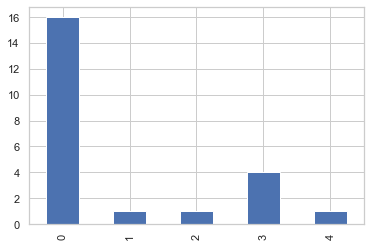

In [30]:
##Evaluate the Cluster Results
LandmarksHispanicPlaces_firstcolumn.Cluster.value_counts().sort_index().plot(kind='bar')

## IV. RESULTS

#### 1. Maps generated with Folium based on the Foursquare API and data sources

In [31]:
#Location of the main Shopping Centers near the zone of interest (Red Circles) 
latitude = 39.0030666
longitude = -76.9721023

map_adelphi_ = folium.Map(location=[latitude, longitude], zoom_start=14)
# add markers to map
for Latitude, Longitude, landmark in zip(shopping_center_loc['Latitude'], shopping_center_loc['Longitude'], shopping_center_loc['Shopping_Center']):
    landmark = folium.Popup(landmark, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=20,
        popup=landmark,
        color='red',
        fill_opacity=0.6,
    ).add_to(map_adelphi_)  
    
map_adelphi_

In [32]:
##Relevant landmarks near Adelphi Center

venues_map = folium.Map(location=[latitude, longitude], zoom_start=16)

# add a red circle marker to represent the point of interest
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Restaurants',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the main places a blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
    # display map
venues_map

In [33]:
##Clustering of relevant venues near Metzerott Plaza
latitude2 = 39.0030666
longitude2 = -76.9721023

map_adelphi2_ = folium.Map(location=[latitude2, longitude2], zoom_start=16)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, name, cluster in zip(LandmarksHispanicPlaces_firstcolumn['lat'], LandmarksHispanicPlaces_firstcolumn['lng'], LandmarksHispanicPlaces_firstcolumn['name'], LandmarksHispanicPlaces_firstcolumn['Cluster']):
    label = folium.Popup("Cluster "+str(cluster)+", "+str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_opacity=0.7).add_to(map_adelphi2_)
        
map_adelphi2_